Prueba concepto

1. Importamos las librerías necesarias

In [1]:
import numpy as np
import random
import math
import openpyxl
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

2. importamos fichero de datos

In [2]:
path = "z:/TFM/vstuttgartmenos55km.xlsx"

In [3]:
vfichero=openpyxl.load_workbook(path, read_only=False,keep_vba=False, data_only=True, keep_links=False)

In [4]:
hojavdatos=vfichero["vdatos"]#


In [5]:
km=[]
litros=[]
kwh=[]
temp=[]


Obtenemos los datos de las hojas de excel

In [6]:
n=2 # primera fila a leer
while hojavdatos.cell(row=n,column=1).value!=None:# 
    km.append(hojavdatos.cell(row=n,column=2).value)
    litros.append(hojavdatos.cell(row=n,column=4).value)
    kwh.append(hojavdatos.cell(row=n,column=7).value)
    temp.append(hojavdatos.cell(row=n,column=12).value)
    n+=1
    

metemos los datos en tensores

In [7]:
vlongitud=len(km)
litros_np=np.array(litros)
litros_np.reshape(vlongitud,1)
kwh_np=np.array(kwh)
kwh_np.reshape(vlongitud,1)
temp_np=np.array(temp)
temp_np.reshape(vlongitud,1)
x=np.empty(shape=(vlongitud, 3),dtype=float)
x[:,0]=litros_np
x[:,1]=kwh_np
x[:,2]=temp_np


In [8]:
km_t=torch.tensor(km).view(-1,1)
x_t=torch.tensor(x,dtype=torch.float32)# para aplicar el linear
x_t.type()


'torch.FloatTensor'

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))


gpu_tensor = torch.as_tensor(x_t).to(device)

#gpu_tensor[0]    
learning_rate = 1e-6  
lre = nn.Linear(in_features=3, out_features=1, bias=True).to(device) 

yhat=lre(gpu_tensor)


loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(lre.parameters(),lr=learning_rate)
print("Parameters w and b: ", list(lre.parameters()))


Parameters w and b:  [Parameter containing:
tensor([[0.2887, 0.1624, 0.4424]], requires_grad=True), Parameter containing:
tensor([-0.5043], requires_grad=True)]


In [10]:
LOSS=[]
km1=[]
for t in range(4000):
    lre.train()
    optimizer.zero_grad()#orden importante
    perdidas= loss_fn(lre(gpu_tensor),km_t )
    loss_fn(lre(gpu_tensor),km_t ).backward()
     #store loss/cost 
   
    LOSS.append(perdidas.item())
    
    optimizer.step()
    
    


# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'Result: km = {lre.bias.item()} + {lre.weight[:, 0].item()} litros + {lre.weight[:, 1].item()} kwh + {lre.weight[:, 2].item()} temp')
#print('Weight Of Network :\n',m.weight)
print(lre.weight.T)
print(lre.state_dict())


Result: km = 1.234637975692749 + 3.645667552947998 litros + 5.398142337799072 kwh + 0.010168535634875298 temp
tensor([[3.6457],
        [5.3981],
        [0.0102]], grad_fn=<PermuteBackward0>)
OrderedDict([('weight', tensor([[3.6457, 5.3981, 0.0102]])), ('bias', tensor([1.2346]))])


In [11]:
sre=(km_t**2).sum()
loss=loss_fn(lre(gpu_tensor),km_t )
print("loss",loss,"sre",sre,"r",1-loss/sre)

loss tensor(7521.2314, grad_fn=<MseLossBackward0>) sre tensor(273195.5625) r tensor(0.9725, grad_fn=<RsubBackward1>)


visualizamos.

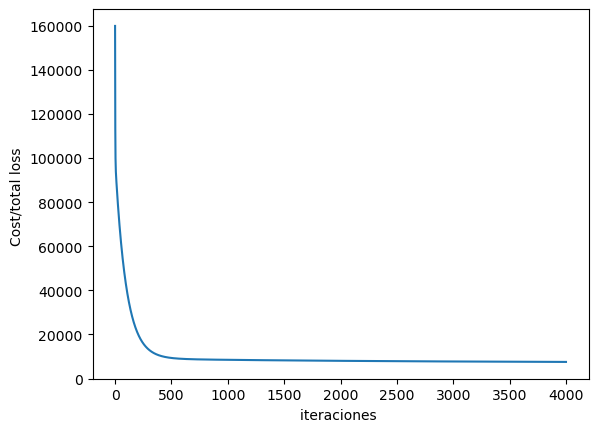

In [12]:
plt.plot(LOSS)
plt.xlabel("iteraciones ")
plt.ylabel("Cost/total loss ")
plt.show()

In [18]:
kmai=torch.zeros(len(yhat), 1)
kmgretl=torch.zeros(len(yhat), 1)
for i2 in range(len(yhat)):
    kmai[i2]=x_t[i2,0]*lre.weight[:, 0].item()+\
                       x_t[i2,1]*lre.weight[:, 1].item()\
                                  +x_t[i2,2]*lre.weight[:, 2].item()\
                                              +lre.bias.item()
    kmgretl[i2]=x_t[i2,0]*8.43169+x_t[i2,1]* 4.94980+x_t[i2,2]* 0.177202-1.88506 



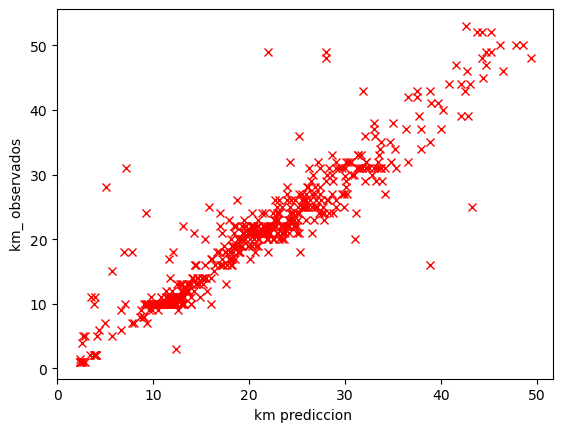

In [26]:




plt.plot(kmai,km_t,'rx',label = 'ai')    
#plt.plot(kmgretl,km_t,'b.', label = 'gretl')   
plt.xlabel("km prediccion ")
plt.ylabel("km_ observados")
plt.show()

In [55]:
yhat_numpy=np.float64(yhat.clone().detach().numpy())# hay que convertir si no no va 
vexcel=[]
hojaresultados=vfichero["vresultados"]
for i4 in range(len(yhat_numpy)):
    vexcel.append(float(yhat_numpy[i4]))# sin el float no se vuelaca a excel

                  
for ia in range(len(vexcel)):
    hojaresultados.cell(row=ia+2, column=2,value= float(km1[ia])) 
    hojaresultados.cell(row=ia+2, column=3,value= float(km2[ia])) 

In [56]:
vfichero.save(filename = path)



In [57]:
print(yhat_numpy)

[[-1.98228061e+00]
 [-5.44509315e+00]
 [-5.82673669e-01]
 [-7.99869061e-01]
 [-2.03822327e+00]
 [-8.51680875e-01]
 [-1.43107593e+00]
 [-3.96109724e+00]
 [-4.22898722e+00]
 [-2.54743719e+00]
 [-6.10672092e+00]
 [-8.18237782e-01]
 [-9.57660317e-01]
 [-2.59840631e+00]
 [-2.80169916e+00]
 [ 4.59551394e-01]
 [ 4.62818682e-01]
 [-1.24687910e-01]
 [-1.73696935e-01]
 [-1.20391369e-01]
 [-9.95997190e-02]
 [ 4.77250516e-02]
 [-2.23369360e-01]
 [ 2.45291024e-01]
 [ 2.24499315e-01]
 [-1.39450073e-01]
 [-1.27449298e+00]
 [-1.65787637e+00]
 [-8.31415534e-01]
 [-9.03015733e-01]
 [-5.99482656e-01]
 [-5.96512318e-01]
 [-2.62569857e+00]
 [-5.27069926e-01]
 [-1.62248433e+00]
 [-5.51143289e-01]
 [-4.69166934e-01]
 [-6.24804974e-01]
 [-5.40749431e-01]
 [-2.89727879e+00]
 [-1.52949417e+00]
 [-7.10723639e-01]
 [-6.63199782e-01]
 [-7.86967278e-01]
 [-2.52630615e+00]
 [-5.54121971e+00]
 [-3.28682184e+00]
 [-1.14912689e+00]
 [-1.14021623e+00]
 [-1.24642029e+01]
 [-2.07459021e+00]
 [-4.76443720e+00]
 [-1.7966004

In [43]:
print(km1)





        
        
               


tensor([[ 3.8046e+01],
        [ 1.6869e+02],
        [ 9.5772e+00],
        [ 1.6178e+01],
        [ 4.3494e+01],
        [ 2.5245e+01],
        [ 2.8651e+01],
        [ 1.2314e+02],
        [ 1.3502e+02],
        [ 4.1547e+01],
        [ 1.8596e+02],
        [ 6.8124e+00],
        [ 1.1792e+01],
        [ 4.9848e+01],
        [ 6.3015e+01],
        [-7.6635e+00],
        [-7.8117e+00],
        [ 7.3897e+00],
        [ 9.6136e+00],
        [ 6.3393e+00],
        [ 5.3958e+00],
        [ 3.6170e+00],
        [ 1.2702e+01],
        [ 3.4076e+00],
        [ 4.3511e+00],
        [ 6.2396e+00],
        [ 3.2558e+01],
        [ 2.8748e+01],
        [ 1.0258e+01],
        [ 8.7541e+00],
        [ 1.0626e+01],
        [ 1.0491e+01],
        [ 5.5490e+01],
        [ 6.9902e+00],
        [ 3.3296e+01],
        [ 7.5668e+00],
        [ 5.1986e+00],
        [ 9.1408e+00],
        [ 6.6782e+00],
        [ 5.4549e+01],
        [ 3.1970e+01],
        [ 9.0906e+00],
        [ 6.9341e+00],
        [ 8